In [1]:
%load_ext cython

In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor as TPE
from time import time

In [7]:
%%cython
import cython
import numpy as np
from cython.parallel cimport prange
from libc.string cimport memset
from libc.stdlib cimport malloc, free
from libc.math cimport exp
cimport cython
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX

cpdef double gen_pure_random():
    return (<double>rand())/(<double>RAND_MAX)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cdef class Domain:
  cdef:
    char [:] spins_mv
    long N
    double J
    double B
    double T
  def __init__(self, long N, char cold_start = 0, double T = 1.0, double J = 1.0, double B = 0.0):
    cdef np.ndarray[np.int8_t, ndim=1, negative_indices=False, mode='c', cast=True] spins
    self.N = N
    self.J = J
    self.B = B
    self.T = T
    if cold_start == -1:
      spins = np.ones((N,), dtype=np.byte)*(-1)
    elif (cold_start):
      spins = np.ones((N,), dtype=np.byte)
    else:
      spins = np.random.randint(0, 2, (N,), dtype=np.byte) * 2 - np.ones((N,), dtype=np.byte)
    self.spins_mv = spins

  def get_spins(self):
    return np.asarray(self.spins_mv)

  cpdef int run_metro(self, double r_ = -1.0, int rx_ = -1):
    cdef double E0
    cdef double E1
    cdef double R
    cdef double r
    E0 = self.E()
    if rx_ == -1:
      tr_idx = int(gen_pure_random() * self.N)
    else:
      tr_idx = rx_
#     tr_idx = np.random.randint(0, self.N)
    self.spins_mv[tr_idx] *= -1
    E1 = self.E()
    if E1 < E0:
      return E1<E0
    else:
      R = exp(-(E1 - E0)/self.T)
      if r_ == -1.0:
        r = gen_pure_random()
      else:
        r = r_
      if R < r:
        self.spins_mv[tr_idx] *= -1
      return R>r

  cpdef run_long_metro(self, long steps, double ensemble_rate = 0.9, char full_log = 0):
    cdef np.ndarray[np.int8_t, ndim=2, negative_indices=False, mode='c'] spin_log
    cdef np.ndarray[np.float64_t, ndim=1, negative_indices=False, mode='c'] elog
    cdef np.ndarray[np.float64_t, ndim=1, negative_indices=False, mode='c'] mlog
    cdef np.ndarray[np.float64_t, ndim=1, negative_indices=False, mode='c'] randoms_doubles
    cdef np.ndarray[np.int64_t, ndim=1, negative_indices=False, mode='c'] randoms_ints
    cdef double[:] randoms_d_mv
    cdef long[:] randoms_i_mv
    cdef char[:,:] spin_log_mv
    cdef double[:] elog_mv
    cdef double[:] mlog_mv
    cdef long i
    cdef pre_step
    cdef long j
    cdef double E2_ = 0
    cdef double E_ = 0
    cdef double M_ = 0
    cdef double C
    cdef double U
    cdef double M
    
    pre_steps = long((<double>steps) * ensemble_rate)
    randoms_doubles = np.random.random((steps,))
    randoms_ints = np.random.randint(0, self.N, (steps,))
    randoms_d_mv = randoms_doubles
    randoms_i_mv = randoms_ints

    spin_log = np.zeros((self.N, steps), dtype=np.byte)
    elog = np.zeros((steps,))
    mlog = np.zeros((steps,))
    spin_log_mv = spin_log
    elog_mv = elog
    mlog_mv = mlog
      
    for i in range(steps):
      spin_log_mv[:, i] = self.spins_mv[:]
      elog_mv[i] = self.E()
      mlog_mv[i] = self.M()
      self.run_metro(randoms_d_mv[i], randoms_i_mv[i])
    
    for i in range(pre_steps, steps):
      E2_ += elog_mv[i]*elog_mv[i]
      E_ += elog_mv[i]
      M_ += mlog_mv[i]
    E2_ /= (<double>self.N)
    E_ /= (<double>self.N)
    M_ /= (<double>self.N)
    
    M = M_
    U = E_
    C = 1.0/(<double>self.N) * (E2_ - E_*E_)
    
    if full_log:
        return spin_log, elog, mlog, C,U,M
    else:
        return spin_log[:, pre_steps:steps], elog[pre_steps:steps], mlog[pre_steps:steps], C,U,M

    
  
  cpdef double E(self):
    cdef double energy = 0
    for i in range(len(self.spins_mv)-1):
      energy += self.spins_mv[i] * self.spins_mv[i+1]
    energy *= self.J
    energy += -self.B*np.sum(self.spins_mv.base)
    return energy

  cpdef double M(self):
    return np.sum(self.spins_mv.base)/self.N

  def get_E(self):
    return self.E()

In [20]:
%%cython
import cython
import numpy as np
from cython.parallel cimport prange
from libc.string cimport memset
from libc.stdlib cimport malloc, free
from libc.math cimport exp
cimport cython
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX

cpdef double gen_pure_random():
    return (<double>rand())/(<double>RAND_MAX)


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cdef class Domain2d:
  cdef:
    char [:,:] spins_mv
    long N
    double J
    double B
    double T
  def __init__(self, long N, char cold_start = 0, double T = 1.0, double J = 1.0, double B = 0.0):
    cdef np.ndarray[np.int8_t, ndim=2, negative_indices=False, mode='c', cast=True] spins
    self.N = N
    self.J = J
    self.B = B
    self.T = T
    if cold_start == -1:
      spins = np.ones((N,N), dtype=np.byte)*(-1)
    elif (cold_start):
      spins = np.ones((N,N), dtype=np.byte)
    else:
      spins = np.random.randint(0, 2, (N,N), dtype=np.byte) * 2 - np.ones((N,N), dtype=np.byte)
    self.spins_mv = spins

  def get_spins(self):
    return np.asarray(self.spins_mv)

  cpdef int run_metro(self, double r_ = -1.0, int rx_ = -1):
    cdef double E0
    cdef double E1
    cdef double R
    cdef double r
    E0 = self.E()
    if rx_ == -1:
      tr_id = long(gen_pure_random() * self.N * self.N)
    else:
      tr_id = rx_
    tr_idx = tr_id // self.N
    tr_idy = tr_id % self.N
#     tr_idx = np.random.randint(0, self.N)
#     tr_idy = np.random.randint(0, self.N)
    self.spins_mv[tr_idx, tr_idy] *= -1
    E1 = self.E()
    if E1 < E0:
      return E1<E0
    else:
      R = exp(-(E1 - E0)/self.T)
      if r_ == -1.0:
        r = gen_pure_random()
      else:
        r = r_
      if R < r:
        self.spins_mv[tr_idx, tr_idy] *= -1
      return R>r

  cpdef run_long_metro(self, long steps, double ensemble_rate = 0.9, char full_log = 0):
#     cdef np.ndarray[np.int8_t, ndim=2, negative_indices=False, mode='c'] spin_log
    cdef np.ndarray[np.float64_t, ndim=1, negative_indices=False, mode='c'] elog
    cdef np.ndarray[np.float64_t, ndim=1, negative_indices=False, mode='c'] mlog
    cdef np.ndarray[np.float64_t, ndim=1, negative_indices=False, mode='c'] randoms_doubles
    cdef np.ndarray[np.int64_t, ndim=1, negative_indices=False, mode='c'] randoms_ints
#     cdef char[:,:] spin_log_mv
    cdef double[:] randoms_d_mv
    cdef long[:] randoms_i_mv
    cdef double[:] elog_mv
    cdef double[:] mlog_mv
    cdef long i
    cdef pre_step
    cdef long j
    cdef double E2_ = 0
    cdef double E_ = 0
    cdef double M_ = 0
    cdef double C
    cdef double U
    cdef double M
    
    pre_steps = long((<double>steps) * ensemble_rate)
    randoms_doubles = np.random.random((steps,))
    randoms_ints = np.random.randint(0, self.N*self.N, (steps,))
    randoms_d_mv = randoms_doubles
    randoms_i_mv = randoms_ints

#     spin_log = np.zeros((self.N, steps), dtype=np.byte)
    elog = np.zeros((steps,))
    mlog = np.zeros((steps,))
#     spin_log_mv = spin_log
    elog_mv = elog
    mlog_mv = mlog
      
    for i in range(steps):
#       spin_log_mv[:, i] = self.spins_mv[:]
      elog_mv[i] = self.E()
      mlog_mv[i] = self.M()
      self.run_metro(randoms_d_mv[i], randoms_i_mv[i])
    
    
    for i in range(pre_steps, steps):
      E2_ += elog_mv[i]*elog_mv[i]
      E_ += elog_mv[i]
      M_ += mlog_mv[i]
    E2_ /= (<double>(steps - pre_steps))*(<double>(steps - pre_steps))
    E_ /= (<double>(steps - pre_steps))
    M_ /= (<double>(steps - pre_steps))
    
    M = M_
    U = E_
    C = 1.0/(<double>self.N) * (E2_ - E_*E_)
    
    if full_log:
        return 0, elog, mlog, C,U,M
    else:
        return 0, elog[pre_steps:steps], mlog[pre_steps:steps], C,U,M

    
  
  cpdef double E(self):
    cdef double energy = 0
    cdef long i
    cdef long j
    for i in range(self.N - 1):
        for j in range(self.N - 1):
          energy += self.spins_mv[i, j] * self.spins_mv[i+1, j] + self.spins_mv[i, j] * self.spins_mv[i, j+1]
    energy *= self.J
    energy += -self.B*np.sum(self.spins_mv.base)
    return energy

  cpdef double M(self):
    return np.sum(self.spins_mv.base)/self.N

  def get_E(self):
    return self.E()

In [12]:
d1 = Domain(1000, 0, B=5, T = 0.5, J = 1)
st, se, sm, cc,uu,mm = d1.run_long_metro(10000, full_log = 1)

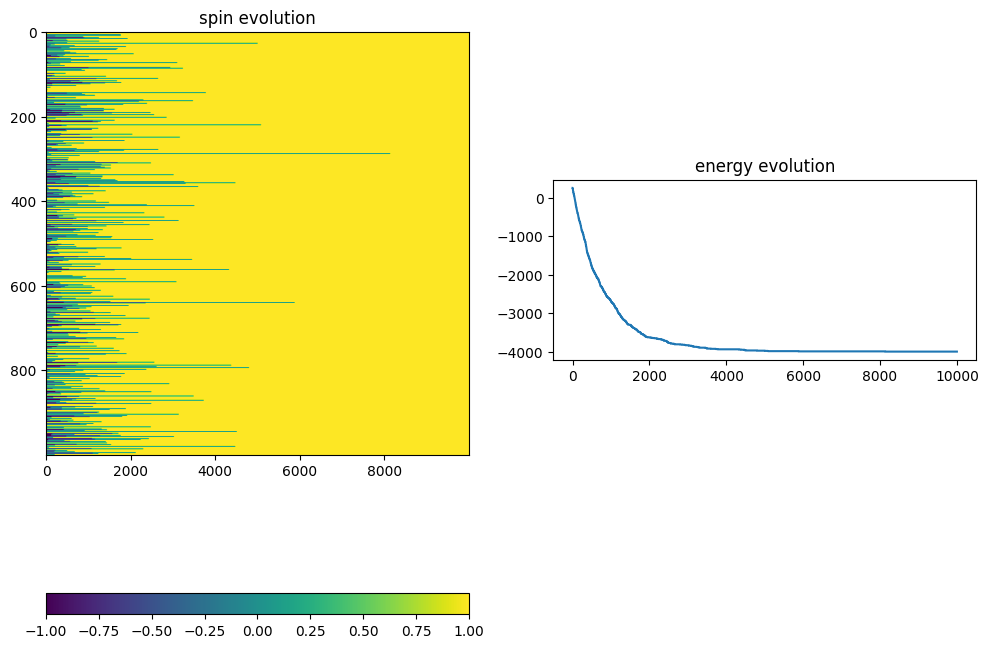

In [13]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,2,1)

cf = ax1.imshow(st, aspect=10)
fig.colorbar(cf, ax=ax1, orientation='horizontal')
ax1.set_title('spin evolution')

ax2 = fig.add_subplot(1,2,2, aspect = 1)
ax2.plot(se)
ax2.set_title('energy evolution')
plt.show()

In [14]:
async def process(d: Domain, steps:int):
    #st, se, sm, cc,uu,mm = d1.run_long_metro(10000, full_log = 1)
    return d.run_long_metro(10000, full_log = 1)

In [15]:
def proc(t):
    return Domain(1000, 0, B=0.1, T = t, J = 1).run_long_metro(10000, ensemble_rate = 0.5)

In [16]:
Ts = np.linspace(0, 5, 50)

array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
       0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
       1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
       1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
       2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
       2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
       3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
       3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
       4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
       4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ])

In [17]:
with TPE(50) as p:
    rr = p.map(proc, Ts)
rr = list(rr)

In [18]:
cc_list = [rri[3] for rri in rr]
uu_list = [rri[4] for rri in rr]
mm_list = [rri[5] for rri in rr]

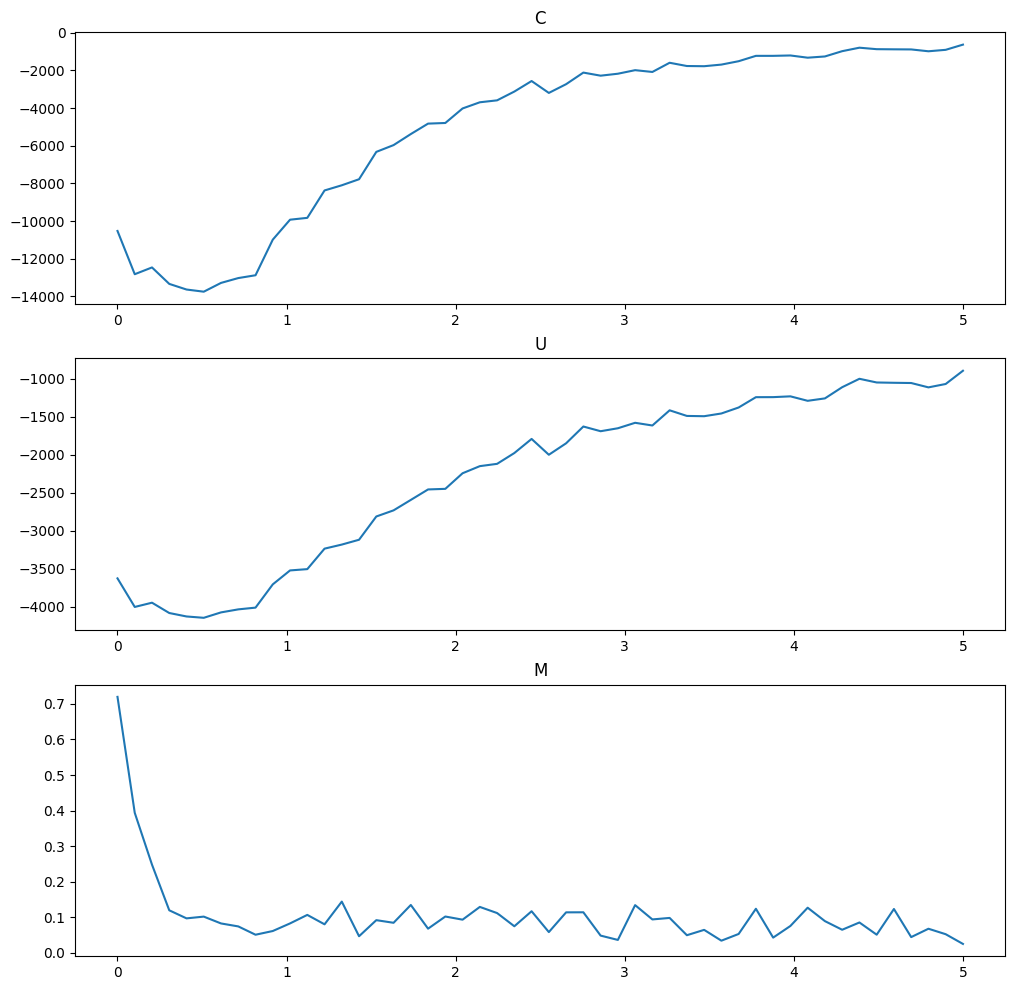

In [19]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,1,1)
ax1.set_title('C')
ax1.plot(Ts, cc_list)
ax2 = fig.add_subplot(3,1,2)
ax2.set_title('U')
ax2.plot(Ts, uu_list)
ax3 = fig.add_subplot(3,1,3)
ax3.set_title('M')
ax3.plot(Ts, mm_list)
plt.show()

In [21]:
def proc(t):
    return Domain2d(50, 0, B=0.1, T = t, J = 1).run_long_metro(15000, ensemble_rate = 0.5)

In [22]:
start = time()
with TPE(50) as p:
    rr = p.map(proc, Ts)
rr = list(rr)
endd = time()
print(f'{endd - start:.3e} sec')

9.475e+01 sec


In [23]:
cc_list = [rri[3] for rri in rr]
uu_list = [rri[4] for rri in rr]
mm_list = [rri[5] for rri in rr]

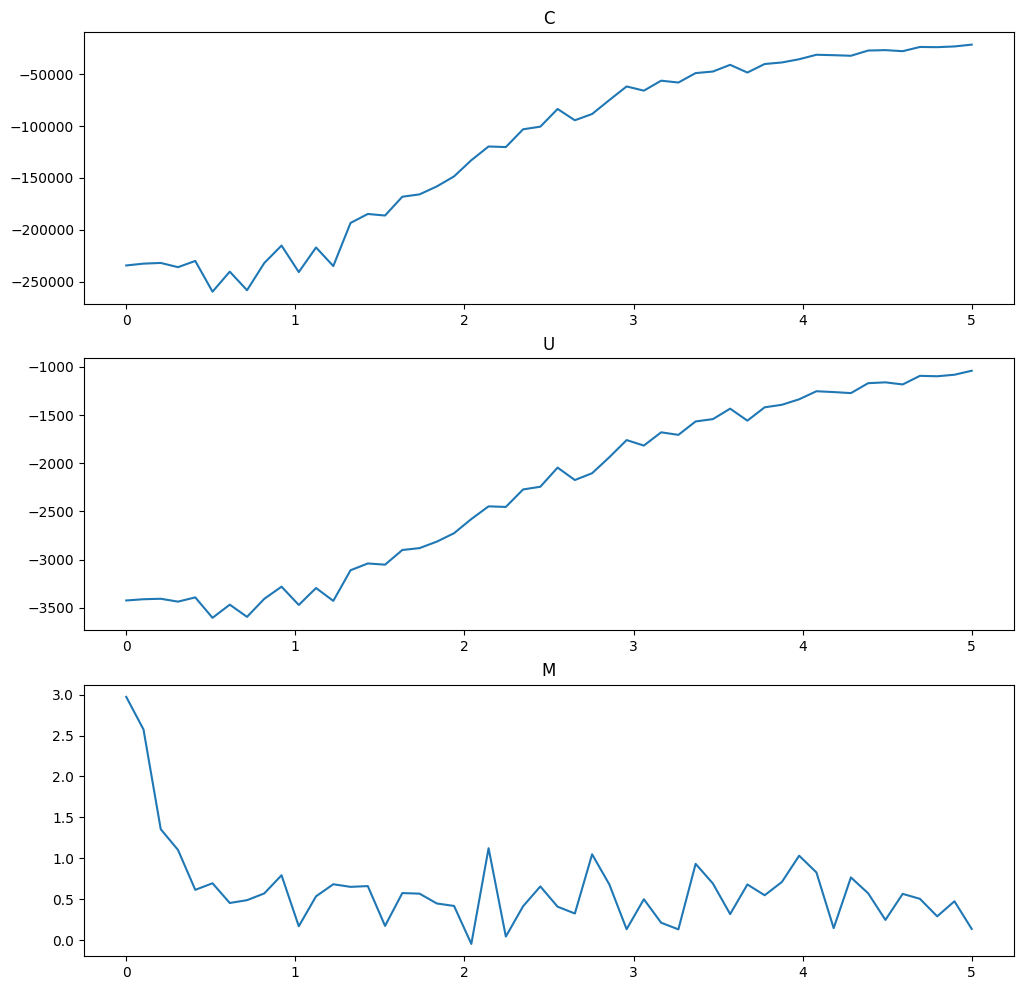

In [24]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,1,1)
ax1.set_title('C')
ax1.plot(Ts, cc_list)
ax2 = fig.add_subplot(3,1,2)
ax2.set_title('U')
ax2.plot(Ts, uu_list)
ax3 = fig.add_subplot(3,1,3)
ax3.set_title('M')
ax3.plot(Ts, mm_list)
plt.show()

In [25]:
d2 = Domain2d(50, 0, B=0.1, T = 0, J = 1)
sst = d2.get_spins()

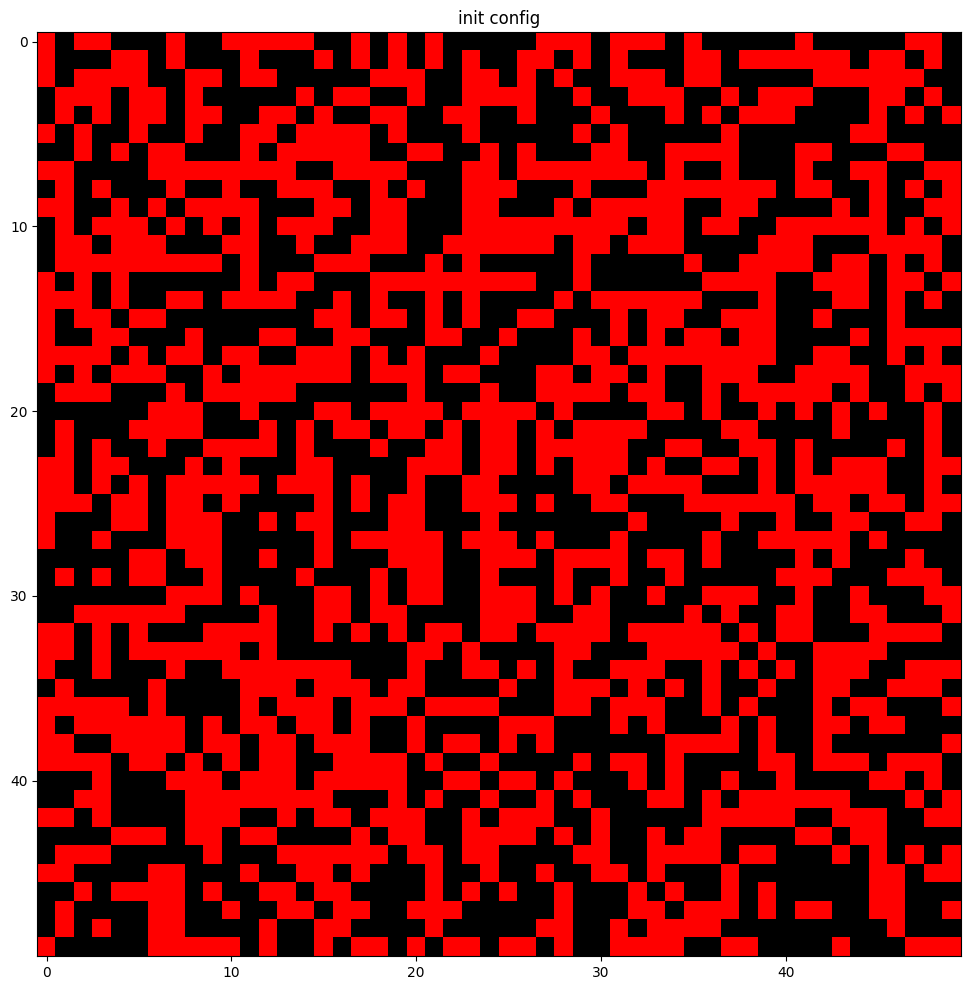

In [26]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,1,1)

cf = ax1.imshow(sst, interpolation='nearest', cmap = 'flag')
ax1.set_title('init config')

plt.show()

In [27]:
d2.run_long_metro(10000, ensemble_rate = 0.5)
sst = d2.get_spins()

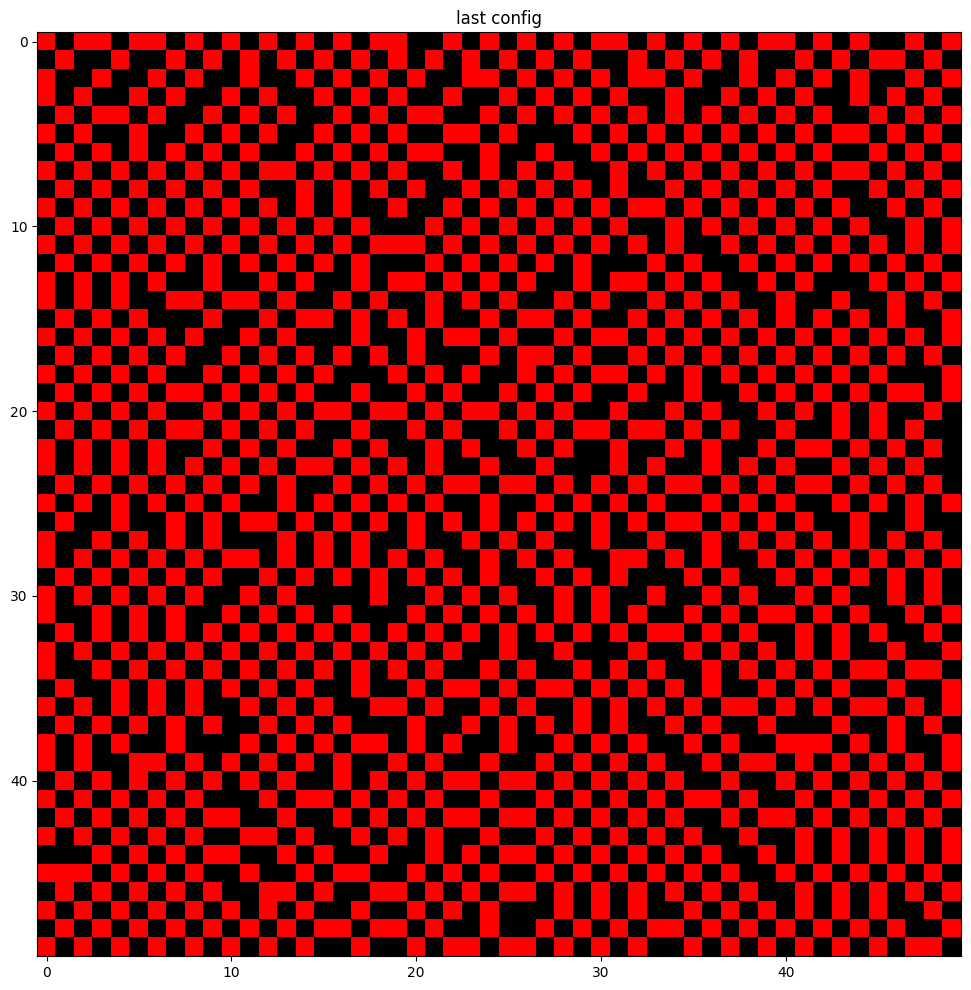

In [28]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,1,1)

cf = ax1.imshow(sst, cmap = 'flag')
ax1.set_title('last config')

plt.show()